In [1]:
import pandas as pd
import re

# stop words
from nltk.corpus import stopwords

# Bag of words
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Word Embedding
from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Transformers
from transformers import AutoTokenizer, AutoModel

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
print(df.shape,"\n")
df.head()

(50000, 2) 



,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# ilk 100 veriyi ele alalım.
df = df.head(100)
df.shape

(100, 2)

In [4]:
# genel veri temizleme 

stop_words = set(stopwords.words("english"))
def clean_text(text):
    text = text.lower() # büyük harf -> küçük harf
    text = re.sub(r"\d+","",text) # rakamları temizleme
    text = re.sub(r"[^\w\s]","",text) # özel karakterleri temizleme
    words = [word for word in text.split() if len(word) > 2] # kısa kelimeleri kaldır
    words = [word for word in words if word not in stop_words] # stopwords' leri kaldır
    text = " ".join(words) # listeyi tekrar string'e çevir
    
    return text

In [5]:
# film yorumlarını al
documents = df["review"]

# metin temizleme
cleaned_doc = [clean_text(doc) for doc in documents]

# örnek temizlenmiş metin
cleaned_doc[:1]

['one reviewers mentioned watching episode youll hooked right exactly happened mebr first thing struck brutality unflinching scenes violence set right word trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr called nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmates turne

## 🧩 Bag of Words (BoW)

Bag of Words, bir metni **kelime frekanslarına** dönüştüren en temel metin temsili yöntemidir.

### 📌 Temel Mantık
- Metindeki kelimelerin **sırası yok sayılır**.
- Sadece **hangi kelime kaç kez geçmiş** buna bakılır.
- Her belge bir **vektör** ile temsil edilir (sparse matrix).

Örnek:
- "kedi seviyor" → {"kedi": 1, "seviyor": 1}
- "kedi kedi koştu" → {"kedi": 2, "koştu": 1}

### ✔️ Avantajları
- Basit ve hızlıdır.
- Küçük veri setlerinde yeterlidir.
- Her ML algoritmasıyla rahatça kullanılabilir.

### ❌ Dezavantajları
- Kelime sırası yok → bağlam kaybolur.
- Semantik bilgi içermez.
- Kelime sayısı büyüdükçe vektör boyutu çok artar (sparse).


In [6]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(cleaned_doc)

# kelime kümesini oluşturma
feature_names = vectorizer.get_feature_names_out()
feature_names # veri setinde 4796 adet benzersiz kelime var.

array(['abbot', 'abbreviated', 'abetted', ..., 'zoo', 'zooms', 'zwick'],
      shape=(4796,), dtype=object)

In [7]:
# vektör temsili
vektor_temsili = X.toarray()
vektor_temsili

# 100 tane metin var (örnek sayısı)
# Her metin 4796 boyutlu bir vektörle temsil ediliyor

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(100, 4796))

In [8]:
df_bow = pd.DataFrame(vektor_temsili, columns=feature_names)
df_bow.head(3)

,abbot,abbreviated,abetted,abiding,ability,able,aboveaverage,abraham,abrahams,absolute,...,zany,zellweger,zerog,zeus,zombie,zombiebr,zone,zoo,zooms,zwick
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# kelime frekansını göster
word_counts = X.sum(axis=0).A1
word_frequeny = dict(zip(feature_names, word_counts))

most_common_5_words = Counter(word_frequeny).most_common(5)
print(f"En çok geçen beş kelime: {most_common_5_words}")

En çok geçen beş kelime: [('movie', np.int64(169)), ('film', np.int64(127)), ('one', np.int64(100)), ('like', np.int64(80)), ('even', np.int64(58))]


## 🔍 TF-IDF (Term Frequency – Inverse Document Frequency)

TF-IDF, bir kelimenin bir belgede **ne kadar önemli** olduğunu gösteren bir metin temsili yöntemidir.

### 🧮 Formüller

### 📌 TF (Term Frequency)

$$
TF(t, d) = \frac{\text{Kelime geçme sayısı}}{\text{Belgedeki toplam kelime sayısı}}
$$

### 📌 IDF (Inverse Document Frequency)

$$
IDF(t) = \log \left( \frac{N}{df_t} \right)
$$

### 📌 TF-IDF

$$
TFIDF(t, d) = TF(t, d) \times IDF(t)
$$

### ✔️ Avantajları
- Sık geçen anlamsız kelimeleri baskılar.
- Önemli kelimeleri vurgular.
- Klasik ML modelleri için çok uygundur.

### ❌ Dezavantajları
- Kelime sırası yoktur → bağlam kaybolur.
- Semantik ilişkileri yakalayamaz.

In [10]:
tfidf_vectorizer = TfidfVectorizer()

# metinleri sayısal hale çevir
X = tfidf_vectorizer.fit_transform(cleaned_doc)

feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names

array(['abbot', 'abbreviated', 'abetted', ..., 'zoo', 'zooms', 'zwick'],
      shape=(4796,), dtype=object)

In [11]:
# vektör temsili
vektor_temsili = X.toarray()

df_tfidf = pd.DataFrame(vektor_temsili, columns=feature_names)
df_tfidf.head(3)

#100 satır → 100 metin
#4796 sütun → 4796 kelime
#Her hücre → TF-IDF ağırlığı

,abbot,abbreviated,abetted,abiding,ability,able,aboveaverage,abraham,abrahams,absolute,...,zany,zellweger,zerog,zeus,zombie,zombiebr,zone,zoo,zooms,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# ortalama TF-IDF skorunu
tf_idf = df_tfidf.mean(axis=0)
tf_idf.sort_values(ascending=False)

movie          0.058055
film           0.042069
one            0.032402
like           0.027955
even           0.023195
                 ...   
obnoxious      0.000372
inoffensive    0.000372
innocent       0.000372
citys          0.000372
wwi            0.000372
Length: 4796, dtype: float64

## 📚 N-Gram Modelleri

N-gram, metni **n kelimeden oluşan parçalar** şeklinde temsil eder.

### 📌 Örnek
Cümle: *"doğal dil işleme güzeldir"*

- **1-gram (unigram):** doğal, dil, işleme, güzeldir  
- **2-gram (bigram):** doğal dil, dil işleme, işleme güzeldir  
- **3-gram (trigram):** doğal dil işleme, dil işleme güzeldir

### ✔️ Avantajları
- BoW/TF-IDF’e göre bağlamı daha iyi yakalar.
- Kelime kombinasyonlarını öğrenir.

### ❌ Dezavantajları
- N büyüdükçe boyut çok artar.
- Sparse matrix oluşturur.
- Uzun bağımlılıkları hâlâ öğrenemez.

In [13]:
vectorizer_unigram = CountVectorizer(ngram_range=(1,1))
vectorizer_bigram = CountVectorizer(ngram_range=(2,2))
vectorizer_trigram = CountVectorizer(ngram_range=(3,3))

In [14]:
# unigram
X_unigram = vectorizer_unigram.fit_transform(cleaned_doc)
unigram_features = vectorizer_unigram.get_feature_names_out()
print(f"Uni-Gram:\n{unigram_features}\n")
print(X_unigram.toarray())
print("="*50)

# bigram 
X_bigram = vectorizer_bigram.fit_transform(cleaned_doc)
bigram_features = vectorizer_bigram.get_feature_names_out()
print(f"\nBi-Gram:\n{bigram_features}\n")
print(X_bigram.toarray())
print("="*50)

# trigram
X_trigram = vectorizer_trigram.fit_transform(cleaned_doc)
trigram_features = vectorizer_trigram.get_feature_names_out()
print(f"\nTri-Gram:\n{trigram_features}\n")
print(X_trigram.toarray())

Uni-Gram:
['abbot' 'abbreviated' 'abetted' ... 'zoo' 'zooms' 'zwick']

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Bi-Gram:
['abbot impersonated' 'abbreviated storyline' 'abetted mother' ...
 'zoo nothing' 'zooms grainy' 'zwick shame']

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Tri-Gram:
['abbot impersonated disappointed' 'abbreviated storyline never'
 'abetted mother brady' ... 'zoo nothing sit' 'zooms grainy blacks'
 'zwick shame however']

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


**Uni-Gram (1-gram)** → Kelimeleri tek tek alır.

*Örnek:* "I love movies" → ["I", "love", "movies"]

**Bi-Gram (2-gram)** → Yan yana gelen iki kelimelik kombinasyonlar.

*Örnek:* "I love movies" → ["I love", "love movies"]

**Tri-Gram (3-gram)** → Üç kelimelik kombinasyonlar.

*Örnek:* "I love movies a lot" → ["I love movies", "love movies a", "movies a lot"]

**Amaç:** Kelime sırasını ve kelimeler arası bağlamı bir nebze yakalamak.

| Model    | Satırlar | Sütunlar                | Hücreler                 |
| -------- | -------- | ----------------------- | ------------------------ |
| Uni-Gram | Metinler | Tek kelime              | Kelimenin metinde sayısı |
| Bi-Gram  | Metinler | 2 kelimelik kombinasyon | Kaç kez geçtiği          |
| Tri-Gram | Metinler | 3 kelimelik kombinasyon | Kaç kez geçtiği          |

## 🔤 Word Embeddings

Word Embeddings, kelimeleri **yoğun (dense)** ve öğrenilmiş vektörler şeklinde temsil eder.  
Amaç, **benzer anlamlı kelimelerin vektör uzayında birbirine yakın olmasıdır.**

### 📌 Popüler Embedding Modelleri
- **Word2Vec** (CBOW, Skip-Gram)
- **GloVe**
- **FastText** (OOV için gelişmiş)

### 🧠 Özellikler
- Semantik ilişkileri yakalar.
- Düşük boyutlu, yoğun vektörler üretir (ör. 100–300 boyut).
- BoW ve TF-IDF’e göre daha anlamlı temsiller sunar.

### 📌 Vektör ilişkisi örneği

$$
\text{vector("king")} - \text{vector("man")} + \text{vector("woman")}
\approx
\text{vector("queen")}
$$

### ✔️ Avantajları
- Anlam ilişkilerini çok iyi yakalar.
- Boyut küçük → daha hızlı hesaplama.
- Derin öğrenme modelleriyle uyumludur.

### ❌ Dezavantajları
- Kelimeler bağlamdan bağımsızdır (ör. *bank* problemi).
- Eğitim süreci maliyetli olabilir.

In [15]:
tokenized_sentences = [simple_preprocess(doc) for doc in cleaned_doc]
tokenized_sentences[0][:10]

['one',
 'reviewers',
 'mentioned',
 'watching',
 'episode',
 'youll',
 'hooked',
 'right',
 'exactly',
 'happened']

In [16]:
# Word2Vec
word2_vec_model = Word2Vec(
    sentences=tokenized_sentences,  # eğitim verisi
    vector_size=50,                 # her kelimenin 50 boyutlu vektörü
    window=5,                        # kelimenin bağlam penceresi
    min_count=1,                     # en az 1 kez geçen kelimeyi al
    sg=0                             # CBOW (sg=1 ise Skip-gram)
)
#vector_size=50 → her kelimeyi 50 boyutlu yoğun vektörle temsil ediyoruz
#window=5 → bir kelimenin çevresindeki ±5 kelimeyi bağlam olarak alıyor
#sg=0 → CBOW kullanıyoruz (kelime bağlamından hedef kelimeyi tahmin eder)

# FastText
fasttext_model = FastText(
    sentences=tokenized_sentences,
    vector_size=50,
    window=5,
    min_count=1,
    sg=0
)

In [17]:
# 'movie' kelimesinin 50 boyutlu vektörü
word_vector = word2_vec_model.wv['movie']
print(word_vector)
print(word_vector.shape)

[-3.01064108e-03  1.50148000e-03  1.01279272e-02  1.79537609e-02
 -2.30927356e-02 -1.95826627e-02  1.87123083e-02  2.69980617e-02
 -2.05727778e-02 -1.10582905e-02  1.17962807e-02 -1.13708246e-02
 -1.05865467e-02  1.71045307e-02 -1.42540624e-02 -9.39988167e-05
  8.85451492e-03  8.12846993e-04 -2.55380608e-02 -2.49318406e-02
  1.68553907e-02  1.69137381e-02  2.42255908e-02 -2.42873817e-03
  1.79231409e-02 -5.79535728e-03 -4.78266180e-03  8.52939487e-03
 -2.45018080e-02 -6.32086024e-03 -1.26428949e-02 -3.36081046e-03
  1.64337214e-02 -1.41683249e-02 -7.99297355e-03  4.50989573e-05
  1.96925551e-02 -1.07392939e-02  1.91798364e-03 -1.38889151e-02
 -1.15780402e-02  6.50742743e-03 -1.81924757e-02 -8.26848485e-03
  1.37968324e-02  2.01460905e-03 -1.93241313e-02  1.31068192e-02
  1.48806311e-02  2.72172838e-02]
(50,)


In [18]:
word2_vec_model.wv.most_similar('movie', topn=5)

[('adventure', 0.557800829410553),
 ('auer', 0.4729858338832855),
 ('get', 0.4682518243789673),
 ('highest', 0.4481760859489441),
 ('still', 0.4433756172657013)]

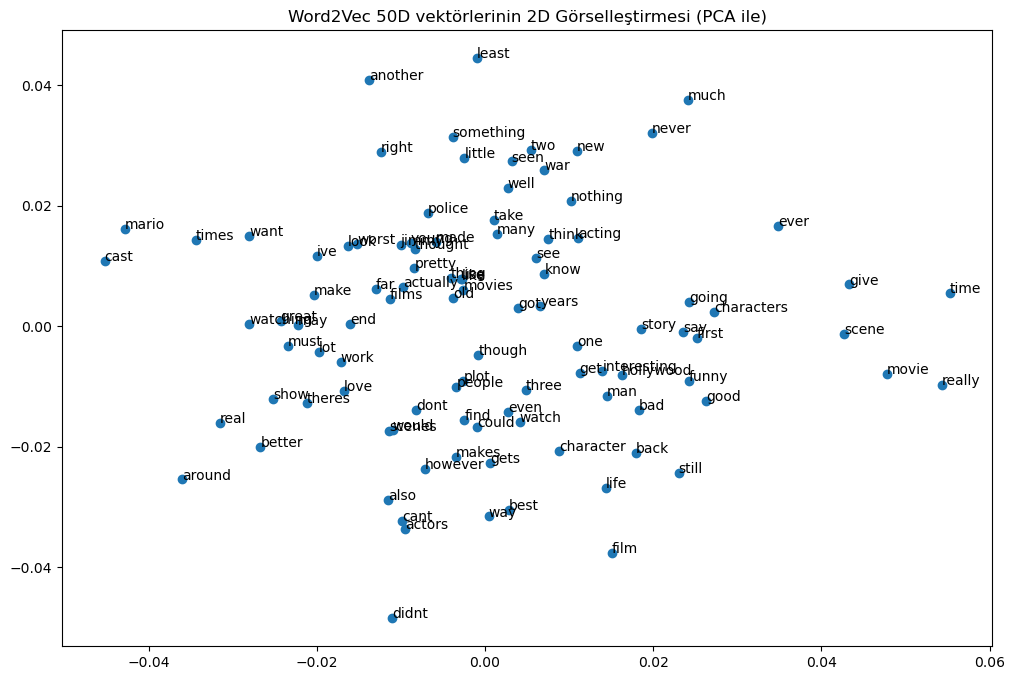

In [19]:
# Sadece örnek 100 kelimeyi al
words = list(word2_vec_model.wv.index_to_key)[:100]
word_vectors = [word2_vec_model.wv[w] for w in words]

# PCA ile 2D'ye indir
pca = PCA(n_components=2)
word_vecs_2d = pca.fit_transform(word_vectors)

# Plot
plt.figure(figsize=(12,8))
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vecs_2d[i,0], word_vecs_2d[i,1]))
plt.title("Word2Vec 50D vektörlerinin 2D Görselleştirmesi (PCA ile)")
plt.show()

## 🤖 Transformer Tabanlı Metin Temsili

Transformer tabanlı modeller (BERT, RoBERTa, GPT vb.), günümüzdeki en gelişmiş metin temsili yöntemleridir.

### 📌 Temel Fikir
- **Self-Attention** mekanizması sayesinde
  - Uzun bağlam ilişkilerini yakalar
  - Cümledeki her kelimeyi diğer kelimelere göre temsil eder

Bu nedenle embedding’ler **bağlama duyarlı (contextualized)** olur.

### 📝 Örnek
"bank" kelimesi:
- "I deposited money in the bank" → *bank = finans*  
- "I sat by the river bank" → *bank = nehir kıyısı*

Aynı kelime, iki farklı embedding üretir.

### 🎯 Üretilen Embedding Türleri
- **CLS embedding** (cümle temsili)
- **Token embedding** (kelime temsili)
- **Sentence Transformers** (semantik benzerlik için)

### ✔️ Avantajları
- Bağlamı çok iyi yakalar.
- En güncel NLP görevlerinde en yüksek doğruluk.
- Hem kelime hem cümle seviyesi temsil üretir.

### ❌ Dezavantajları
- Hesaplama maliyeti yüksektir.
- GPU gerektirebilir.

In [20]:
# model ve tokenizer yükle
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [21]:
# ilk metni tokenlara çevirme
inputs = tokenizer(cleaned_doc[0], return_tensors="pt")

In [22]:
import torch
# modeli kullanarak metin temsili oluştur
with torch.no_grad(): 
    outputs = model(**inputs)

In [23]:
last_hidden_state = outputs.last_hidden_state 

first_token_embedding = last_hidden_state[0,0,:].numpy()
print(f"Örnek Metin Temsili:\n{first_token_embedding[0:5]}")

Örnek Metin Temsili:
[-0.00803003  0.02271153  0.3142795   0.07646848 -0.22340778]
